In [1]:
import pandas as pd
import numpy as np
import string as s
import matplotlib.pyplot as plt
import nltk
import pickle
import re
import math
import random
import warnings
import seaborn as sns
from wordcloud import WordCloud
from sklearn.utils import resample,shuffle
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
%matplotlib inline
stop = stopwords.words('english')
warnings.filterwarnings('ignore')
lemmatizer = WordNetLemmatizer()

In [2]:
df = pd.read_json('Musical_Instruments_5.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
len(df)

10261

In [4]:
df = df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful','summary', 'unixReviewTime', 'reviewTime'], axis=1)

In [5]:
df['reviewText'] = df['reviewText'].str.replace('\d+', '') #deleting numbers
df['reviewText'] = df['reviewText'].str.lower() #make all the letters lowercase
df['reviewText'] = df.apply(lambda row: nltk.word_tokenize(row['reviewText']), axis=1) #tokenize the sentences

In [6]:
def punctuation_remove(token): #remove function for punctuations
    clean_words=[]
    for i in token:
        for j in s.punctuation:
            i=i.replace(j,'')
        clean_words.append(i)
    return clean_words

In [7]:
df['reviewText'] = df['reviewText'].apply(punctuation_remove)

In [8]:
def space_remove(token): #remove function for extra spaces
    non_space_list=[]
    for i in token:
        i = i.strip()
        non_space_list.append(i)
    return non_space_list

In [9]:
df['reviewText'] = df['reviewText'].apply(space_remove)

In [10]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [11]:
df['reviewText'] = df['reviewText'].apply(lemmatize_text)
df['reviewText'] = df.reviewText.apply(lambda x: [w.strip() for w in x if w.strip() not in stop])

In [12]:
def group(x):
    if x >= 4:
        return "positive"
    elif x == 3:
        return "neutral"
    else:
        return 'negative'

In [13]:
df["CommentAnalize"] = df["overall"].apply(group)
df = df.drop(['overall'] , axis = 1)

In [14]:
df.head()

,reviewText,CommentAnalize
0,"[much, write, , doe, exactly, supposed, , filt...",positive
1,"[product, doe, exactly, quite, affordablei, re...",positive
2,"[primary, job, device, block, breath, would, o...",positive
3,"[nice, windscreen, protects, mxl, mic, prevent...",positive
4,"[pop, filter, great, , look, performs, like, s...",positive


In [15]:
df.CommentAnalize.value_counts()

positive    9022
neutral      772
negative     467
Name: CommentAnalize, dtype: int64

In [16]:
df['CommentAnalize'] = df['CommentAnalize'].replace({'positive':1, 'negative':-1 , 'neutral':0})
class_1,class_2,class_3 = df.CommentAnalize.value_counts()
c1 = df[df['CommentAnalize'] == 1]
c2 = df[df['CommentAnalize'] == 0]
c3 = df[df['CommentAnalize'] == -1]
df_3 = c3.sample(class_1, replace = True)
df_2 = c2.sample(class_1, replace = True)
oversampled_df = pd.concat([df_3,df_2,c1], axis=0)

In [17]:
oversampled_df['data'] = ""
for i in oversampled_df.index:
    oversampled_df.at[i, 'data'] = " ".join(item for item in df.at[i, 'reviewText'])
data = oversampled_df['data']

X = data
y = oversampled_df['CommentAnalize']

In [18]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X).toarray() 
pickle.dump(vectorizer.vocabulary_,open("musical.pkl","wb"))

In [19]:
tfidfconverter = TfidfTransformer()  
X = tfidfconverter.fit_transform(X)  

In [20]:
train_x,test_x,train_y,test_y=train_test_split(X ,y,test_size=0.20,random_state=1)

In [21]:
NB=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
NB.fit(train_x,train_y)
y_pred=NB.predict(test_x)

In [22]:
print("Accuracy score:" , "{:.4f}".format(accuracy_score(test_y,y_pred)))

Accuracy score: 0.9025


In [23]:
print("Confusion Matrix: " , '\n' , confusion_matrix(test_y, y_pred))

Confusion Matrix:  
 [[1807   35   15]
 [  25 1758   32]
 [ 119  302 1321]]


In [24]:
print("Pretty Confusion Matrix:")
display(pd.DataFrame(confusion_matrix(test_y, y_pred, labels=np.unique(test_y)),
                         index=['pred:' + str(x) for x in np.unique(test_y)],
                         columns=['true:' + str(x) for x in np.unique(test_y)]))

Pretty Confusion Matrix:


,true:-1,true:0,true:1
pred:-1,1807,35,15
pred:0,25,1758,32
pred:1,119,302,1321


In [25]:
print("Classification Report")
target_names = ['negative','neutral','positive']
print(classification_report(test_y, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

    negative       0.93      0.97      0.95      1857
     neutral       0.84      0.97      0.90      1815
    positive       0.97      0.76      0.85      1742

    accuracy                           0.90      5414
   macro avg       0.91      0.90      0.90      5414
weighted avg       0.91      0.90      0.90      5414



In [26]:
w_data = data.str.cat(sep=' ')
w_data = word_tokenize(w_data)
frequency_dist = FreqDist(w_data)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10]

['nt', 'guitar', 'wa', 'one', 'sound', 'string', 'like', 'use', 'get', 'pedal']

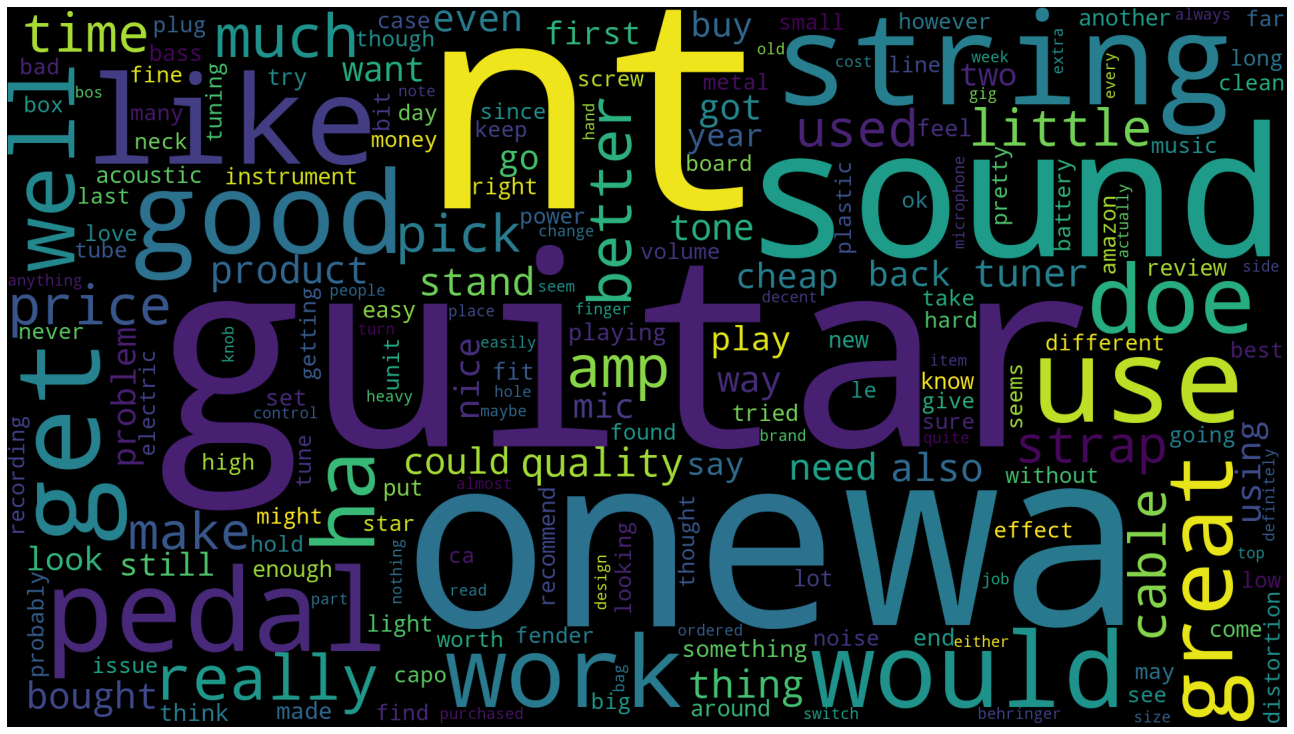

In [27]:
sns.set();
wordcloud = WordCloud(width=1920, #1920 x 1080 
                      height=1080,
                      stopwords=stopwords.words('english')).generate_from_frequencies(frequency_dist)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

fig.savefig('word_cloud.jpg', dpi=100)